### Projet KmemBERT
#### Interprétation patient
##### Script pour la visualisation de patient du Centre Léon Bérard

Pour exécuter le script, vous aurez besoin :
- Si besoin, un jeu de données (format .csv) avec les colonnes suivantes : Noigr, Texte, Date cr, Date deces (si vous souhaitez utiliser des vrais CR issus d'une database).
- Du dossier kmembert-base associé au modèle KmemBERT Base.
- Du fichier json (large.json) contenant tous les mots du vocabulaire médical, disponible sur le GitHub du projet.

Auteur de ce script : Théo Di Piazza (Centre Léon Bérard), avec l'aide des scripts de Mohamed Aymen Qabel.

##### Chargement des librairies et création du argparse

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import argparse
import json
import shap
from torch.serialization import save
from collections import OrderedDict
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt

from kmembert.models import HealthBERT
from kmembert.utils import create_session

# Import argparse
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")
parser.add_argument("-nr", "--nrows", type=int, default=10, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
parser.add_argument("-ng", "--noigr", type=int, default=2, 
    help="The Noigr of a patient")
args = parser.parse_args("")

##### Chargement du modèle

In [2]:
# Load Model
_, _, device, config = create_session(args)
model = HealthBERT(device, config)

> DEVICE:  cpu
> ROOT:    c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT
> SESSION: c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT\results\ipykernel_launcher_22-06-13_15h02m03s

Using mode density (Health BERT checkpoint kmembert-base)

Loading camembert and its tokenizer...
if config.resume from health_bert.py
Resuming with model at kmembert-base...
Successfully loaded



##### Textes à interpréter

In [3]:
# Textes à interpréter
CR1 = "Karnofsky = 30 %, PS = 4. Evolutivité de la maladie : Pas de signe d'évolutivité de la maladie."
CR2 = "L'état général du patient continue à s'améliorer."
CR3 = "Le Karnofsky est actuellement à 30-40 % mais manifestement s'améliore puisque le patient marche désormais."
CR4 = "On a une situation de complications multiples (infectieuses, rénales et digestives)."
# id du patient
id_noigr = 2022

texts_to_classify = np.array([CR1, CR2, CR3, CR4])

#### A partir des CR disponibles, on calcule à partir de chaque compte-rendu l'importance de chaque mot

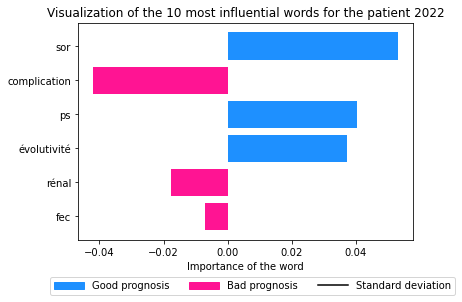

In [4]:
# Calcul de l'importance et affichage du BarPlot des mots les plus importants

# 5 étapes pour afficher le barplot.
# ETAPE 1/5 - Texte à classifier : limite de 1500 caractères.
# ETAPE 2/5 - Pour chaque Compte-Rendu (CR), calcul de l'importance des tokens.
# ETAPE 3/5 - Suppression des tokens doublons. Si tokens récurrent : somme des importances à chaque occurence de ce token.
# ETAPE 4/5 - Conserver seulement les mots du vocabulaire médical pour le BarPlot.
# ETAPE 5/5 - Affichage du BarPlot et save la figure.


# Read medical vocabulary
f = open("medical_voc/large.json", encoding='utf-8')
dictio = json.load(f)
med_voc = []
for i in range(len(dictio)):
    med_voc.append(dictio[i][0])

################################
# ETAPE 1/5 - Texte à classifier
# On limite la taille de chaque CR à 1500 documents pour éviter qu'ils soient trop long et pas interprétables (Computational Complexity)
n_max = 1500
# For Loop on text to classify ["text1..", ..., "text4.."]
for i in range(len(texts_to_classify)):
    # If length is too long, select only 1500 first caracters
    if(len(texts_to_classify[i])>n_max):
        n_remove = (len(texts_to_classify[i])-n_max)/2
        texts_to_classify[i] = texts_to_classify[i][n_remove:(n_remove+n_max)]

################################
# ETAPE 2/5 - Pour chaque CR, calcul de l'importance des tokens

# Pour chaque CR, on calcule l'importe de chaque token et on conserve les résultats dans word_attributes
# word_attributes est une liste de 4 dictionnaire (1 pour chaque CR) de la forme : {token: importance_token, ...}.
word_attributes = []
for ehr in texts_to_classify:
    cls_explainer = SequenceClassificationExplainer(
        model.camembert,
        model.tokenizer)
    word_attributions = cls_explainer(ehr)
    word_attributes+= [dict(word_attributions)]

################################
# ETAPE 3/5 - Suppression des tokens doublons et somme de leur importance
# Compute word importance by sum
result = {}
n_documents = len(word_attributes)
for d in word_attributes:
    for k in d.keys():
        # Si key presente, ajout de la valeur
        if k in result:
            result[k].append(d[k]/n_documents)
        # Sinon, creation de la liste puis ajout de la valeur
        else:
            result[k] = []
            result[k].append(d[k]/n_documents)
# Compute standart deviation for each token
result_sd = {}
for k, v in result.items():
    result_sd[k] = np.std(v)

################################
# ETAPE 4/5 - conserve seulement les mots du vocabulaire médical
# Create dict to stock word+attributions for words in medical voc
result_medicam = {}
result_medicam_sd = {}
# For each word of the text to classify
for k, v in result.items():
    # If special character present, replace it with lower case
    new_k = k
    if("▁" in k):
        new_k = k.replace("▁", "").lower()
    elif("_" in k):
        new_k = k.replace("_", "").lower()
    # Add word to dict with transformed string, if in medical voc
    if new_k in med_voc:
        result_medicam[new_k] = v
        result_medicam_sd[new_k] = result_sd[k]
    
# Compute mean of word importance
result_mean = {k: np.mean(result_medicam[k]) for k in result_medicam.keys() & result_medicam}

################################
# ETAPE 5/5 - Affichage du BarPlot et save la figure.

# Get 10 most important by mean
show_n = 10
final_dict = dict(sorted(result_mean.items(), key=lambda item: abs(item[1]), reverse=True)[:show_n])

# Get 10 most importants word with values as sum
final_dict_sd = dict((k, result_medicam_sd[k]) for k in list(final_dict.keys()))

# BARH Plot with everyword - without filter on medical
show_n = 10
final_dict = dict(sorted(result_mean.items(), key=lambda item: abs(item[1]), reverse=True)[:show_n])
################################################################
# Plot the results for the word attributes (green for positive contribution and red for negative contribution)
x = list(final_dict.keys())
y = list(final_dict.values())
colors = ['deeppink']*show_n 
colors = ['deeppink']*len(y) 
for i in range(len(y)):
    if y[i]>0:
        colors[i] = 'dodgerblue'
fig, ax = plt.subplots()
plt.barh(list(reversed(x)), list(reversed(y)), color=list(reversed(colors)))

i = show_n-1
for k, v in final_dict.items():
    if(final_dict_sd[k] != 0):
        if(v>=0):
            ax.hlines(y=i, xmin=final_dict[k]-final_dict_sd[k], xmax=final_dict[k]+final_dict_sd[k], linewidth=1, colors='black')
            ax.vlines(x=final_dict[k]-final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
            ax.vlines(x=final_dict[k]+final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
        else:
            ax.hlines(y=i, xmin=final_dict[k]-final_dict_sd[k], xmax=final_dict[k]+final_dict_sd[k], linewidth=1, colors='black')
            ax.vlines(x=final_dict[k]-final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
            ax.vlines(x=final_dict[k]+final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
    i -= 1

plt.title(f'Visualization of the 10 most influential words for the patient {id_noigr}')

# Add legend
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
blue_patch = mpatches.Patch(color='dodgerblue')
pink_patch = mpatches.Patch(color='deeppink')
line_b, = plt.plot([0], [0], color='black')

plt.xlabel("Importance of the word")

plt.legend([blue_patch, pink_patch, line_b], 
            ['Good prognosis', 'Bad prognosis', 'Standard deviation'], 
            numpoints=1, handlelength=3,
            loc='lower left',
            bbox_to_anchor=(-0.1, -0.275), ncol=3)

# Save the figure
plt.savefig(f'graphs/interpretation/test_{id_noigr}_boxplotSD.png', bbox_inches='tight')

##### Affichage du texte avec les mots surlignés

In [5]:
# Affichage du texte avec les mots surlignes

# 2 étapes pour afficher le texte surligné:
# ETAPE 1/2 - Creation du dictionnaire result_plot avec, pour chaque token, sa valeur d'importance.
# ETAPE 2/2 - Mise en forme et affichage du texte.

################################
# ETAPE 1/2 - Creation du dictionnaire result_plot {token: value}.

# Modification du dictionnaire pour afficher les résultats
# Création de 'result_plot' pour stocker tous les mots et leur valeur d'attributions
result_plot = {}
# Pour chaque mot et sa valeur extraite des textes à classifier
# k : le token, v : valeur d'importance du token
for k, v in result.items():
    new_k = k
    #  If special character present, replace it and save with lower case
    if("▁" in k):
        new_k = k.replace("▁", "")
        result_plot[new_k] = 0
    elif("_" in k):
        new_k = k.replace("_", "")
        result_plot[new_k] = 0
    result_plot[new_k] = -v[0] # Negative to adjust shap module, idk why...

################################
# ETAPE 2/2 - Mise en forme et affichage
# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])
################################
# END

#### FIN